In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 

import sys
sys.path.append(f'/home/beans/bespoke')
from constants import *

import matplotlib.pyplot as plt
from viz_utils import draw_wps
from blender_dataloader import *
from constants import *
from imports import *
from train_utils import get_torque

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [ ]:
get_obs_per_sec()

In [ ]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

In [ ]:
dataloader = BlenderDataloader("trn", 6)

In [ ]:
%%time
batch, is_first_in_seq = dataloader.get_batch()

(
    img, 
    aux_model,
    aux_calib,
    wp_angles,
    wp_headings,
    wp_curvatures,
    wp_rolls,
    wp_zs,
    aux_targets,
    to_pred_mask,
) = batch

is_first_in_seq

In [ ]:
wp_angles.shape, wp_headings.shape, wp_curvatures.shape, wp_rolls.shape, wp_zs.shape

In [ ]:
aux_model.shape, aux_calib.shape, aux_targets.shape

In [ ]:
# Angles
plt.hist((wp_angles*to_pred_mask).flatten().detach().cpu().numpy())

In [ ]:
# headings
plt.hist((wp_headings*to_pred_mask).flatten().detach().cpu().numpy())

In [ ]:
# curvatures
plt.hist((wp_curvatures*to_pred_mask).flatten().detach().cpu().numpy())

In [ ]:
# rolls
plt.hist((wp_rolls*to_pred_mask).flatten().detach().cpu().numpy())

In [ ]:
# zs
plt.hist((wp_zs*to_pred_mask).flatten().detach().cpu().numpy())

In [ ]:
to_pred_mask.sum() / to_pred_mask.numel()

In [ ]:
# Has stop
plt.hist(aux_targets[:,:,0].flatten().detach().cpu().numpy())

In [ ]:
# Stop dist
plt.hist((aux_targets[:,:,1]*aux_targets[:,:,0]).flatten().detach().cpu().numpy())

In [ ]:
# has lead
plt.hist(aux_targets[:,:,3].flatten().detach().cpu().numpy())

In [ ]:
# lead dist
plt.hist((aux_targets[:,:,4]*aux_targets[:,:,3]).flatten().detach().cpu().numpy())

In [ ]:
# lead speed
plt.hist((aux_targets[:,:,5]*aux_targets[:,:,3]).flatten().detach().cpu().numpy())

In [2]:
from models import *
m = EffNet().to(device) 
#model_stem = "12.10_e45"
#m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m_{model_stem}.torch"), strict=False)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_aa-80ba17e4.pth" to /home/beans/.cache/torch/hub/checkpoints/tf_efficientnet_b6_aa-80ba17e4.pth


In [ ]:
with torch.no_grad():
    with torch.cuda.amp.autocast(): 
        wps_preds, aux_preds, obs_net_out  = m(img, aux_model, aux_calib)

In [21]:
wp_angles_pred, wp_headings_pred, wp_curvatures_pred, wp_rolls_pred, wp_zs_pred = torch.chunk(wps_preds, 5, -1)

In [22]:
aux_preds.shape

torch.Size([6, 8, 12])

In [52]:
sigmoid = torch.nn.Sigmoid()

In [53]:
aux_preds[0,:,0], sigmoid(aux_preds[0,:,0])

(tensor([-2.1582, -2.0605, -1.9668, -1.9727, -1.9160, -1.8926, -1.8809, -1.9043],
        device='cuda:0', dtype=torch.float16),
 tensor([0.1036, 0.1130, 0.1227, 0.1221, 0.1283, 0.1310, 0.1323, 0.1296],
        device='cuda:0', dtype=torch.float16))

In [59]:

for n, p in m.aux_targets_head.named_parameters():
    print(n, p)

weight Parameter containing:
tensor([[ 0.5089,  0.2160, -0.0199,  ..., -0.1058, -0.0317,  0.0344],
        [ 0.0519, -0.0124, -0.0011,  ...,  0.0072, -0.0134,  0.0552],
        [-0.0240, -0.0270, -0.0179,  ...,  0.0257, -0.0073,  0.0328],
        ...,
        [ 0.0177,  0.0288, -0.0310,  ...,  0.0253, -0.0062, -0.0398],
        [-0.0027,  0.0138, -0.0070,  ...,  0.0114,  0.0399, -0.0231],
        [-0.0187,  0.0375,  0.0265,  ...,  0.0281,  0.0436,  0.0289]],
       device='cuda:0', requires_grad=True)
bias Parameter containing:
tensor([-0.9226,  0.6607,  0.0261,  0.6406,  1.2272, -0.3009,  0.0173,  0.0087,
        -0.0193, -0.0284,  0.0211,  0.0253], device='cuda:0',
       requires_grad=True)


In [62]:
m.aux_targets_head.weight[0]

tensor([ 5.0895e-01,  2.1597e-01, -1.9882e-02, -2.9578e-02,  2.5771e-01,
         1.1977e-02, -8.3835e-02,  7.0657e-02, -3.9417e-01, -5.8633e-02,
         1.4129e-01,  7.8153e-02, -2.3752e-01, -2.8642e-02, -3.3252e-02,
        -1.0416e-01,  5.3596e-02, -1.6957e-01, -1.2881e-01, -6.9477e-02,
        -9.8141e-02, -3.6094e-01,  8.4937e-02, -2.0017e-01, -6.2556e-02,
        -7.5789e-02, -3.5080e-01,  8.0234e-02, -2.8151e-02, -1.6422e-01,
        -1.9552e-01, -1.6208e-01, -9.3518e-02, -1.0807e-02, -4.5706e-03,
        -1.6113e-02, -3.0870e-01, -9.4229e-03, -2.9200e-01, -1.3414e-01,
        -3.3439e-02, -2.8382e-01, -5.6518e-02, -2.0200e-03,  2.2979e-02,
        -7.1281e-02, -1.8984e-02,  5.0464e-02,  5.8284e-03,  1.2990e-02,
         6.5122e-01,  2.8938e-02, -1.4806e-01, -7.1491e-03,  1.1533e-02,
         1.8735e-01,  4.9591e-02,  3.3706e-02, -1.1973e-01, -1.1923e-01,
         2.9193e-03,  4.7431e-02, -1.9419e-01, -1.3376e-01,  2.8882e-02,
        -1.7879e-01,  4.8548e-02, -2.1958e-01, -3.5

In [18]:
t = get_torque(wp_angles, aux)
plt.hist(t.cpu().numpy().flatten())

NameError: name 'aux' is not defined

In [17]:
abs(t).max()

tensor(12240.8799, device='cuda:0')

(array([10., 19., 12.,  1.,  1.,  2.,  1.,  1.,  0.,  1.]),
 array([   2.3530273,  102.832375 ,  203.31172  ,  303.79108  ,
         404.27042  ,  504.74976  ,  605.2291   ,  705.70844  ,
         806.1878   ,  906.6671   , 1007.1465   ], dtype=float32),
 <BarContainer object of 10 artists>)

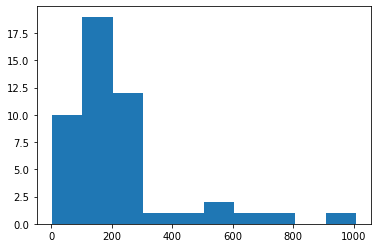

In [18]:
td = abs(t[:,1:,:] - t[:,:-1,:])
plt.hist(td.cpu().numpy().flatten())

In [19]:
abs(td).max()

tensor(1007.1465, device='cuda:0')

In [8]:
import subprocess

In [9]:
# Load up membank from ssd to shm
subprocess.run("cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank", shell=True)

CompletedProcess(args='cp -R /media/beans/beans_data/blender_membank /dev/shm/blender_membank', returncode=0)

In [ ]:
# save membank to ssd
subprocess.run("cp -R /dev/shm/blender_membank /media/beans/beans_data/blender_membank", shell=True)